In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import Levenshtein
from datasets import load_metric
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


/home/mtafresh/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cpu')

In [8]:
df = pd.read_csv("filtered_data/changes_new.csv")

In [10]:
df

,Unnamed: 0,project_file,commit,commit_message,date,old,new
0,0,BradyFU/Woodpecker_models/entity_extractor.py,8eef8561a06b056525ad4dc4e7dd1bed3e14436a,update code,2023-10-24,['You are a language assistant that helps to e...,['You are a language assistant that helps to e...
1,1,AmineDiro/cria_python/langchain_openai.py,e98ec6e3f907c84ea64ca79f2778b5f36ccb1da6,small fix langchain,2023-08-08,"[""\nUSER: You are a helpful, medical specialis...","[""\nUSER: You are a helpful, medical specialis..."
2,2,UranusSeven/llama_generative_agent_generative_...,fb169f71f0851167e24186131d9eb368d9268c3e,ENH: better prompts,2023-05-05,['\n{q1}?\nContext from memory:\n{relevant_mem...,['{q1}?\nContext from memory:\n{relevant_memor...
3,3,yoheinakajima/babyagi_babycoder/babycoder.py,4d5002262e36a361ef9c4d057989ece22f1ce304,get os name,2023-05-02,['You are an AGI agent responsible for creatin...,['You are an AGI agent responsible for creatin...
4,4,juntoku9/edupal_firebase_functions/functions/s...,cc91125ab816f695eb335beb8da9846430cde3c3,some clean up and bug fixes,2023-10-25,"[' you are a happy dog chatting with children,...","[' you are a happy dog chatting with children,..."
...,...,...,...,...,...,...,...
1791,1791,sweepai/sweep_sweepai/core/context_pruning.py,bc9bfc0351261b66d9bdcb8b08b27df75f24d712,Feat/fast and better context (#3532),2024-04-11,"['PLACEHOLDERPLACEHOLDER', 'You are a brillian...","['PLACEHOLDERPLACEHOLDER', ""You are a brillian..."
1792,1792,thiswillbeyourgithub/DocToolsLLM_DocToolsLLM.py,fb876ba5fae3e4eff683739f38919c40794eed54,feat: added task==search,2023-12-01,['Given the following conversation and a follo...,['Given the following conversation and a follo...
1793,1793,thiswillbeyourgithub/DocToolsLLM_DocToolsLLM.py,0802de797b7946e54e55db61f8d40065c00afbc6,fix dedent,2023-12-10,['Given the following conversation and a follo...,['\n Given the followin...
1794,1794,thiswillbeyourgithub/DocToolsLLM_DocToolsLLM.py,7e22a317e07323fe4c34e0beeecade79576d7a99,feat: allow the llm to give its opinion if the...,2024-05-01,"[""Given the following question and document te...","[""Given the following question and document te..."


In [20]:
def parse_to_list(string_set):
    return list(ast.literal_eval(string_set))

def compute_rouge_l_similarity(s1, s2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(s1, s2)
    return score['rougeL'].fmeasure  # f-measure is a harmonic mean of precision and recall

def compute_rouge_l_similarity_matrix(array1, array2):
    matrix = np.zeros((len(array1), len(array2)))
    for i, s1 in enumerate(array1):
        for j, s2 in enumerate(array2):
            matrix[i, j] = compute_rouge_l_similarity(s1, s2)
    return matrix

def levenshtein_similarity(s1, s2):
    return 1 - (Levenshtein.distance(s1, s2) / max(len(s1), len(s2)))

def compute_levenshtein_similarity_matrix(array1, array2):
    matrix = np.zeros((len(array1), len(array2)))
    for i, s1 in enumerate(array1):
        for j, s2 in enumerate(array2):
            matrix[i, j] = levenshtein_similarity(s1, s2)
    return matrix

def match_strings(array1, array2, similarity_matrix, threshold=0.2):
    matches = []
    sim_matrix = similarity_matrix.copy()
    
    while True:
        max_index = np.unravel_index(np.argmax(sim_matrix, axis=None), sim_matrix.shape)
        max_similarity = sim_matrix[max_index]
        
        # For ROGUE-L
        if max_similarity >= 1:
            sim_matrix[max_index[0], :] = -1
            sim_matrix[:, max_index[1]] = -1

            array1[max_index[0]] = None
            array2[max_index[1]] = None

        if max_similarity < threshold:
            break
        
        match = {
            "from_array1": array1[max_index[0]],
            "from_array2": array2[max_index[1]],
            "similarity": max_similarity
        }
        matches.append(match)
        
        sim_matrix[max_index[0], :] = -1
        sim_matrix[:, max_index[1]] = -1
        
        array1[max_index[0]] = None
        array2[max_index[1]] = None
        
        if all(el is None for el in array1):
            break
    
    return matches

In [21]:
ms = []

for index, row in df.iterrows():
    if index % 100 == 0:
        print(index)
    old_prompts = parse_to_list(row['old'])
    new_prompts = parse_to_list(row['new'])

    # old_embeddings = model.encode(old_prompts)
    # new_embeddings = model.encode(new_prompts)

    # similarity_matrix = cosine_similarity(old_embeddings, new_embeddings)
    # similarity_matrix = compute_levenshtein_similarity_matrix(old_prompts, new_prompts)
    similarity_matrix = compute_rouge_l_similarity_matrix(old_prompts, new_prompts)


    matches = match_strings(old_prompts, new_prompts, similarity_matrix)

    for match in matches:
        ms.append({
            "project_file": row['project_file'],
            "commit": row['commit'],
            "commit_message": row["commit_message"],
            "date": row["date"],
            "old": match["from_array1"],
            "new": match["from_array2"],
            "similarity": match["similarity"]
        })


    # for i in range(len(old_prompts)):
    #     similarity_scores = similarity_matrix[i]
    #     most_similar_index = np.argmax(similarity_scores)

    #         # print("OLD:")
    #         # print(old_prompts[i])
    #         # print("NEW:")
    #         # print(new_prompts[most_similar_index])
    #         # print("=========================================")
    #     if similarity_scores[most_similar_index] > 0.2:
    #         new_row = {
    #             "project_file": row['project_file'], 
    #             "commit": row['commit'], 
    #             "old": old_prompts[i], 
    #             "new": new_prompts[most_similar_index],
    #             "similarity": similarity_scores[most_similar_index]
    #         }
                
    #         new_df = new_df.append(new_row, ignore_index=True)
new_df = pd.DataFrame(ms)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [22]:
new_df.head()
new_df.to_csv('output_7.csv', index=False, line_terminator='\n')

/tmp/ipykernel_3029380/884060710.py:2: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  new_df.to_csv('output_7.csv', index=False, line_terminator='\n')


In [23]:
len(new_df)

14063

In [59]:
df_no_duplicates = new_df.drop_duplicates()

In [25]:
len(df_no_duplicates)

3230

In [27]:
df_no_duplicates.to_csv('output_7.csv', index=False, lineterminator='\n')

In [60]:
df_no_duplicates.dropna(subset=['old', 'new'], inplace=True)

for index, row in df_no_duplicates.iterrows():
    df_no_duplicates.at[index, 'prompt_length_old'] = len(row['old'].split())
    df_no_duplicates.at[index, 'prompt_length_new'] = len(row['new'].split())

df_no_duplicates

/tmp/ipykernel_3029380/1172792937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates.dropna(subset=['old', 'new'], inplace=True)
/tmp/ipykernel_3029380/1172792937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates.at[index, 'prompt_length_old'] = len(row['old'].split())
/tmp/ipykernel_3029380/1172792937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,project_file,commit,commit_message,date,old,new,similarity,prompt_length_old,prompt_length_new
1,BradyFU/Woodpecker_models/entity_extractor.py,8eef8561a06b056525ad4dc4e7dd1bed3e14436a,update code,2023-10-24,"Given a sentence, extract the existent entitie...","Given a sentence, extract the entities within ...",0.851541,192.0,155.0
4,AmineDiro/cria_python/langchain_openai.py,e98ec6e3f907c84ea64ca79f2778b5f36ccb1da6,small fix langchain,2023-08-08,"\nUSER: You are a helpful, medical specialist....","\nUSER: You are a helpful, medical specialist....",0.985507,68.0,68.0
6,UranusSeven/llama_generative_agent_generative_...,fb169f71f0851167e24186131d9eb368d9268c3e,ENH: better prompts,2023-05-05,\n{q1}?\nContext from memory:\n{relevant_memor...,Context from memory:\n,0.545455,7.0,3.0
18,yoheinakajima/babyagi_babycoder/babycoder.py,4d5002262e36a361ef9c4d057989ece22f1ce304,get os name,2023-05-02,You are an AGI agent responsible for executing...,You are an AGI agent responsible for executing...,0.976562,124.0,124.0
21,juntoku9/edupal_firebase_functions/functions/s...,cc91125ab816f695eb335beb8da9846430cde3c3,some clean up and bug fixes,2023-10-25,"you are a happy dog chatting with children, y...","you are a happy dog chatting with children, y...",0.965517,29.0,29.0
...,...,...,...,...,...,...,...,...,...
14053,sweepai/sweep_sweepai/core/context_pruning.py,bc9bfc0351261b66d9bdcb8b08b27df75f24d712,Feat/fast and better context (#3532),2024-04-11,## Stored Files\nHere are the files that you h...,## Stored Files\nDO NOT CALL THE STORE OR VIEW...,0.633333,20.0,30.0
14054,sweepai/sweep_sweepai/core/context_pruning.py,bc9bfc0351261b66d9bdcb8b08b27df75f24d712,Feat/fast and better context (#3532),2024-04-11,You are a brilliant engineer assigned to solve...,You are a brilliant engineer assigned to solve...,0.488812,290.0,281.0
14059,thiswillbeyourgithub/DocToolsLLM_DocToolsLLM.py,7e22a317e07323fe4c34e0beeecade79576d7a99,feat: allow the llm to give its opinion if the...,2024-05-01,"Given the following question and answers, you ...","Given the following question and answers, you ...",0.723077,46.0,82.0
14061,thiswillbeyourgithub/DocToolsLLM_DocToolsLLM.py,af87e516db34b996c6daead53b12f38d0ac1beca,remove irrelevant context when combining answers,2024-05-01,You are an assistant for question-answering ta...,You are an assistant for question-answering ta...,0.958333,48.0,50.0


In [62]:
df_no_duplicates = df_no_duplicates[(df_no_duplicates['prompt_length_old'] > 15) & (df_no_duplicates['prompt_length_new'] > 15)]
df_no_duplicates.to_csv('output_7_15.csv', index=False, lineterminator='\n')

In [39]:
df = pd.read_csv("./output_7_15.csv")

In [40]:
len(df)

1346

In [41]:
df_no_duplicates = df.drop_duplicates(subset=['old', 'new'])

In [42]:
len(df_no_duplicates)

1262

In [83]:
df_count = df_no_duplicates['project_file'].value_counts().reset_index()
df_count.columns = ['Project_file', 'Count']

In [84]:
bins_table = []

# Calculate the number of entries for each bin condition
for i in range(1, 11):
    count_in_bin = df_count[df_count['Count'] >= i].shape[0]
    bins_table.append({'Count >=': i, 'Number of Project_files': count_in_bin})

# Convert the list to a DataFrame
bins_df = pd.DataFrame(bins_table)

# Display the resulting bins table
bins_df

,Count >=,Number of Project_files
0,1,333
1,2,179
2,3,116
3,4,81
4,5,63
5,6,49
6,7,36
7,8,33
8,9,30
9,10,25


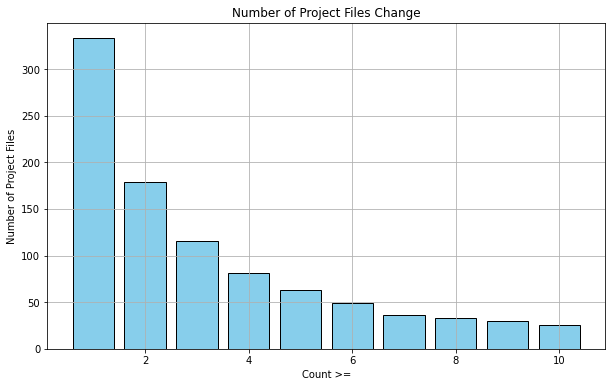

In [87]:
import matplotlib.pyplot as plt

# Plotting the bins_df DataFrame
plt.figure(figsize=(10, 6))
plt.bar(bins_df["Count >="], bins_df['Number of Project_files'], color='skyblue', edgecolor='black')

plt.xlabel('Count >=')
plt.ylabel('Number of Project Files')
plt.title('Number of Project Files Change')
plt.grid(True)

plt.show()

In [81]:
df_count = df_count[df_count['Count'] >= 4]

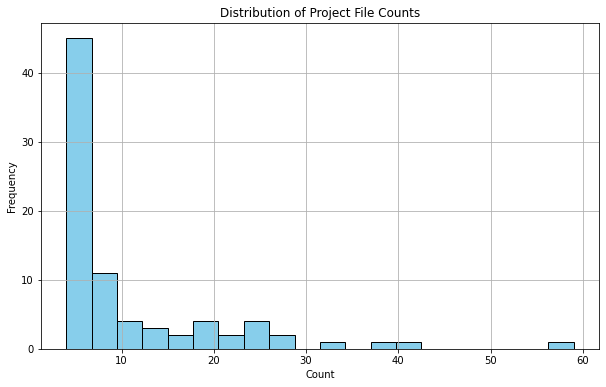

In [82]:
import matplotlib.pyplot as plt

# Plot a histogram of the 'Count' column in df_count
plt.figure(figsize=(10, 6))
plt.hist(df_count['Count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Project File Counts')
plt.grid(True)
plt.show()

In [12]:
repos_name

0                    BradyFU
1                  AmineDiro
2              yoheinakajima
3                   juntoku9
4                   juntoku9
                ...         
1341                 sweepai
1342                 sweepai
1343    thiswillbeyourgithub
1344    thiswillbeyourgithub
1345    thiswillbeyourgithub
Name: project_file, Length: 1262, dtype: object

In [47]:
df_no_duplicates['similarity'] = df_no_duplicates['similarity'].round(2)

/tmp/ipykernel_3141900/994181833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['similarity'] = df_no_duplicates['similarity'].round(2)


In [48]:
df_no_duplicates['similarity_bin'] = pd.cut(df_no_duplicates['similarity'], bins=np.arange(0, 1.01, 0.01), include_lowest=True)

/tmp/ipykernel_3141900/1085648753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['similarity_bin'] = pd.cut(df_no_duplicates['similarity'], bins=np.arange(0, 1.01, 0.01), include_lowest=True)


In [49]:
bin_counts = df_no_duplicates['similarity_bin'].value_counts()

# Filter out bins with fewer than 2 samples
valid_bins = bin_counts[bin_counts >= 2].index
df_filtered = df_no_duplicates[df_no_duplicates['similarity_bin'].isin(valid_bins)]

# Step 2: Stratified sampling
try:
    sampled_df, _ = train_test_split(
        df_filtered,
        test_size=(len(df_filtered) - 200),
        stratify=df_filtered['similarity_bin'],
        random_state=42
    )
except ValueError as e:
    print(f"Error during stratified sampling: {e}")
    sampled_df = df_filtered.sample(n=200, random_state=42)  # Fallback to random sampling

# Dropping the 'similarity_bin' column if it was only used for stratification
sampled_df = sampled_df.drop(columns=['similarity_bin'])


In [55]:
sampled_df['old']  = sampled_df['old'].str.strip()
sampled_df['new']  = sampled_df['new'].str.strip()
sampled_df.to_csv('output_sampled.csv', index=False, lineterminator='\n')

In [60]:
print(len(df['project_file'].unique()))

342


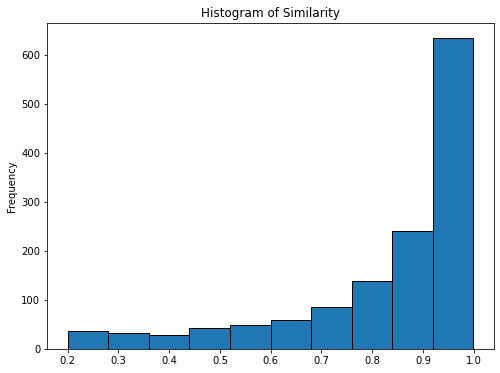

In [61]:
plt.figure(figsize=(8, 6))
plt.hist(df['similarity'], bins=10, edgecolor='black')
plt.title('Histogram of Similarity')
plt.ylabel('Frequency')

# Display the histogram
plt.show()